<a href="https://colab.research.google.com/github/woodstone10/deep_learning_study-python/blob/main/NLP_sentiment_analysis_Korean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Korean NLP sentiment analysis using KoNLPy

---



 Install KoNLPy https://konlpy.org/en/latest/

In [1]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
     |████████████████████████████████| 19.4MB 177kB/s 
     |████████████████████████████████| 92kB 11.7MB/s 
     |████████████████████████████████| 460kB 54.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-release /etc/os-release
+ '[' '/etc/lsb-release:DISTRIB_ID=Ubuntu
/etc/lsb-release:DISTRIB_DESCRIPTION="Ubuntu 18.04.5

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import requests
from bs4 import BeautifulSoup
import urllib.request
from konlpy.tag import Mecab

# **Data**

For simple, get text file of Naver movie review from github instead of Web crawling

https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

In [3]:
ratings_train = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
ratings_test = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

In [4]:
train_data = pd.read_table(ratings_train)
test_data = pd.read_table(ratings_test)
train_data.shape

(150000, 3)

In [5]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# **Data pre-processing**

In [6]:
train_data['document'].nunique()

146182

In [7]:
train_data['label'].nunique()

2

1. check duplicate

In [8]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data.shape

(146183, 3)

2. check null

In [9]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [10]:
train_data = train_data.dropna(how='any')
train_data.shape

(146182, 3)

3. check Korean language only

In [11]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
train_data.head()

,id,document,label
0,9976970,아더빙진짜짜증나네요목소리,0
1,3819312,흠포스터보고초딩영화줄오버연기조차가볍지않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소이야기구먼솔직히재미는없다평점조정,0
4,6483659,사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...,1


In [12]:
train_data['document'].replace('', np.nan, inplace=True)
train_data.isnull().sum()

id            0
document    789
label         0
dtype: int64

In [22]:
train_data = train_data.dropna(how='any')
train_data.shape

(145393, 3)

test data pre-processing

In [23]:
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')

**serial data**

In [24]:
mecab = Mecab()
X_train = []
for sentence in train_data['document']:
  X_train.append([word for word in mecab.morphs(sentence)])
X_train[:3]

[['아', '더', '빙', '진짜', '짜증', '나', '네', '요목', '소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다']]

In [25]:
X_test = []
for sentence in test_data['document']:
  X_test.append([word for word in mecab.morphs(sentence)])
X_test[:3]

[['굳', 'ㅋ'],
 ['뭐',
  '야',
  '이',
  '평점',
  '들',
  '은',
  '나쁘',
  '진',
  '않',
  '지만',
  '점',
  '짜리',
  '는',
  '더더욱',
  '아니',
  '잖아'],
 ['지루',
  '하',
  '지',
  '는',
  '않',
  '은데',
  '완전',
  '막장',
  '임',
  '돈',
  '주',
  '고',
  '보',
  '기',
  '에',
  '는']]

**Tokenizer** encode every character as an integer

In [26]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train) 
tokenizer.word_index

{'이': 1,
 '는': 2,
 '영화': 3,
 '다': 4,
 '고': 5,
 '하': 6,
 '의': 7,
 '도': 8,
 '가': 9,
 '은': 10,
 '에': 11,
 '을': 12,
 '한': 13,
 '보': 14,
 '게': 15,
 '들': 16,
 '지': 17,
 '를': 18,
 '있': 19,
 '없': 20,
 '좋': 21,
 '나': 22,
 '었': 23,
 '는데': 24,
 '만': 25,
 '너무': 26,
 '봤': 27,
 '적': 28,
 '안': 29,
 '로': 30,
 '정말': 31,
 '으로': 32,
 '것': 33,
 '지만': 34,
 '네요': 35,
 '어': 36,
 '음': 37,
 '같': 38,
 '아': 39,
 '진짜': 40,
 '재밌': 41,
 '에서': 42,
 '했': 43,
 '기': 44,
 '않': 45,
 '네': 46,
 '았': 47,
 '거': 48,
 '수': 49,
 '되': 50,
 '면': 51,
 '과': 52,
 '인': 53,
 'ㅋㅋ': 54,
 '말': 55,
 '연기': 56,
 '점': 57,
 '잘': 58,
 '최고': 59,
 '평점': 60,
 '주': 61,
 '이런': 62,
 '내': 63,
 '던': 64,
 '와': 65,
 '할': 66,
 '어요': 67,
 '겠': 68,
 '왜': 69,
 '스토리': 70,
 '습니다': 71,
 '해': 72,
 'ㅋㅋㅋ': 73,
 '아니': 74,
 '듯': 75,
 '드라마': 76,
 '그': 77,
 '생각': 78,
 '사람': 79,
 '싶': 80,
 '더': 81,
 '감동': 82,
 '때': 83,
 '배우': 84,
 '까지': 85,
 '함': 86,
 '본': 87,
 '보다': 88,
 '좀': 89,
 '만들': 90,
 '뭐': 91,
 '내용': 92,
 '감독': 93,
 '알': 94,
 '볼': 95,
 '라': 96,
 '그냥': 97,
 '재미

In [27]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq = words_freq + value
  if value < threshold:
    rare_cnt += 1
    rare_freq = rare_freq + value

print(words_cnt)
print(rare_cnt)
print(rare_cnt/words_cnt*100)
print(rare_freq/words_freq*100)

58107
35844
61.686199597294646
1.850548373000224


In [28]:
vocab_size = words_cnt - rare_cnt + 2
vocab_size

22265

In [29]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train) 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

**Padding** for the same length

In [31]:
max(len(i) for i in X_train)

95

In [32]:
sum(map(len, X_train)) / len(X_train)

16.132654254331364

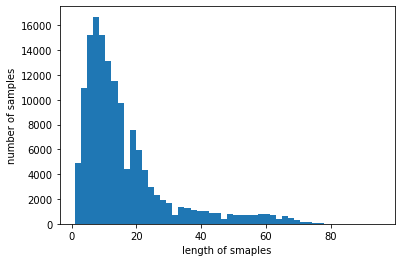

In [33]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of smaples')
plt.ylabel('number of samples')
plt.show()

In [34]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=60)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=60)

# **Model**

In [35]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, 100),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy", 
              optimizer="rmsprop",
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2226500   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,343,877
Trainable params: 2,343,877
Non-trainable params: 0
_________________________________________________________________


In [36]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [37]:
history = model.fit(X_train, y_train, 
                    batch_size=60,
                    validation_split=0.2,
                    epochs=15)

Epoch 1/15
1939/1939 [==============================] - 62s 15ms/step - loss: 0.4475 - acc: 0.7859 - val_loss: 0.3544 - val_acc: 0.8383
Epoch 2/15
1939/1939 [==============================] - 29s 15ms/step - loss: 0.3298 - acc: 0.8556 - val_loss: 0.3348 - val_acc: 0.8544
Epoch 3/15
1939/1939 [==============================] - 28s 14ms/step - loss: 0.2971 - acc: 0.8723 - val_loss: 0.3251 - val_acc: 0.8595
Epoch 4/15
1939/1939 [==============================] - 27s 14ms/step - loss: 0.2751 - acc: 0.8850 - val_loss: 0.3181 - val_acc: 0.8618
Epoch 5/15
1939/1939 [==============================] - 28s 14ms/step - loss: 0.2550 - acc: 0.8954 - val_loss: 0.3347 - val_acc: 0.8546
Epoch 6/15
1939/1939 [==============================] - 28s 15ms/step - loss: 0.2410 - acc: 0.9026 - val_loss: 0.3288 - val_acc: 0.8657
Epoch 7/15
1939/1939 [==============================] - 27s 14ms/step - loss: 0.2219 - acc: 0.9114 - val_loss: 0.3310 - val_acc: 0.8608
Epoch 8/15
1939/1939 [==========================

In [38]:
model.evaluate(X_test, y_test)

1507/1507 [==============================] - 5s 3ms/step - loss: 0.4794 - acc: 0.8408


[0.4794175624847412, 0.8408006429672241]

# Visualization

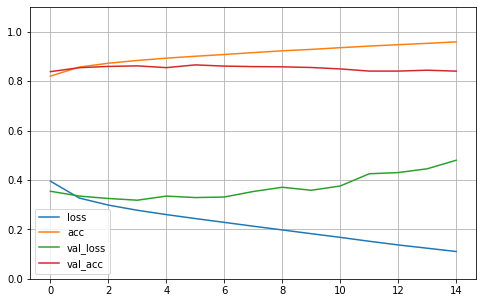

In [39]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0,1.1)
plt.show()

overfitting observed ->need dropout

# Predict

data from https://movie.naver.com/movie/bi/mi/basic.nhn?code=194022

In [70]:
def predict(sentence):
  token = [word for word in mecab.morphs(sentence)]
  sequences = tokenizer.texts_to_sequences([token])
  pad = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=60)
  score = float(model.predict(pad))
  if score > 0.5:
    print("{} \n -> Positive {:.2f}%".format(sentence, score*100))
  else:
    print("{} \n -> Negative {:.2f}%".format(sentence, (1-score)*100))

In [71]:
predict('레트로가 유행이라고 영화도 레트로로 가 버림. 소재가 딱히.... 영화 만든 노력이 가상함.')

레트로가 유행이라고 영화도 레트로로 가 버림. 소재가 딱히.... 영화 만든 노력이 가상함. 
 -> Negative 98.46%


In [72]:
predict('영상미와 연출이 돋보이네요 아쉬운점도있으나 오랜만에 정통멜로영화 재밋게봤습니다')

영상미와 연출이 돋보이네요 아쉬운점도있으나 오랜만에 정통멜로영화 재밋게봤습니다 
 -> Positive 99.97%


In [73]:
predict('오랜만에 자극적이지 않은 멜로 영화를 보고 왔네요. 영상미가 넘 아름다워서 간만에 힐링되는 영화 입니다.')

오랜만에 자극적이지 않은 멜로 영화를 보고 왔네요. 영상미가 넘 아름다워서 간만에 힐링되는 영화 입니다. 
 -> Positive 99.95%


In [74]:
predict('시대는 21세기인데 영화가 19세기말 같은 느낌. \
 배우들 연기력으로도 커버가 어렵다는건 연출의 극단성 때문이 아닐까성인이건 , \
 학창시절이건 좀 더 세밀하개 표현했다면 좋았을텐데 아쉬움. 그래도 이런 레트로 감성 좋다면 츄촌')

시대는 21세기인데 영화가 19세기말 같은 느낌.  배우들 연기력으로도 커버가 어렵다는건 연출의 극단성 때문이 아닐까성인이건 ,  학창시절이건 좀 더 세밀하개 표현했다면 좋았을텐데 아쉬움. 그래도 이런 레트로 감성 좋다면 츄촌 
 -> Negative 94.99%


In [75]:
predict('편집이 너무 몰입감 떨어뜨립니다. \
단서를 보여줄 때는 확실하게 보여주어야 하는데희미하게 보여주고 다음 상황을 연개 할 때 이해가 가는게 조금 걸릴 정도입니다... \
뭔가 급하게 편집한 듯한 느낌이 많이 드네요.확고한 클로즈업을 많이 잡아 줬으면 어땠을까 합니다.')

편집이 너무 몰입감 떨어뜨립니다. 단서를 보여줄 때는 확실하게 보여주어야 하는데희미하게 보여주고 다음 상황을 연개 할 때 이해가 가는게 조금 걸릴 정도입니다... 뭔가 급하게 편집한 듯한 느낌이 많이 드네요.확고한 클로즈업을 많이 잡아 줬으면 어땠을까 합니다. 
 -> Positive 50.21%
